# 深層学習day2

# 再帰型ニューラルネットワークの概念 

### RNNとは
* 時系列データに対応可能な、ニューラルネットワーク
___

### 時系列データ
* 時間的順序を追って一定間隔ごとに観察される
* 相互に統計的依存関係が認められる
* 例...音声データ、テキストデータ
___

### RNNの全体像
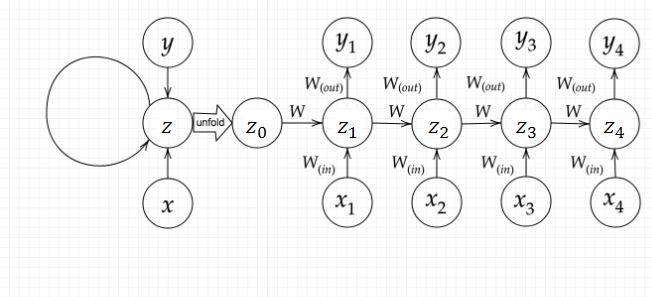
* 時刻tの中間層は、同じ時刻tの入力層からのインプットに加えて、前の時刻t-1の中間層からのインプットも受け取る→時刻間の影響を考慮したニューラルネットワークを作ることが可能
* 再帰的構造を持ったニューラルネットワークなので、Recursive Neural Networkと呼ぶ
* RNNでは、再帰的に出現する同一のネットワーク構造のことをセルと呼ぶ
___

### RNNの数式的記述
$$
u^t=W_{(in)}x^t+Wz^{t-1}+b\\
z^t=f(W_{(in)}x^t+Wz^{t-1}x^t+b)\\
v^t=W_{(out)}z^t+c\\
y^t=g(W_{(out)}z^t+c)
$$
___

### RNNのコード
```python
u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
z[:,t+1] = functions.sigmoid(u[:,t+1])

np.dot(z[:,t+1].reshape(1, -1), W_out)
y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
```
___

### 確認テスト①
#### Q.
RNNのネットワークには大きくわけて3つの重みがある。1つは入力から現在の中間層を定義する際にかけられる重み、1つは中間層から出力を定義する際にかけられる重みである。残り1つの重みについて説明せよ。
#### A.
前の時刻t-1の中間層からのインプットにかかる重み
___

### RNNの特徴
* 時系列モデルを扱うには、初期の状態と過去の時間t-1の状態を保持し、そこから次の時間でのtを再帰的に求める再帰構造が必要になる
___

### BPTT
* RNNにおいての誤差逆伝播手法
* 最後の時刻であるTから最初の0に向かって伝播していく
* すべての時系列データがなければ学習を行うことができないことが問題点
___

### 確認テスト②
#### Q.
$$
z=t^2\\t=x+y
$$
連鎖律の原理を使い、dz/dxを求めよ。
#### A.
$
\frac{\partial z}{\partial x}
=\frac{\partial z}{\partial t}\frac{\partial t}{\partial x}
=2t\\
=2(x+y)
$
___

### BPTTの数学的記述
$$
\frac{\partial E}{\partial W_{(in)}}=
\frac{\partial E}{\partial u^t}\left[\frac{\partial u^t}{\partial W_{(in)}}\right]^T=
\delta^t[x^t]^T\\
\frac{\partial E}{\partial W_{(out)}}=
\frac{\partial E}{\partial v^t}\left[\frac{\partial v^t}{\partial W_{(out)}}\right]^T=
\delta^{out,t} [z^t]^T\\
\frac{\partial E}{\partial W}=
\frac{\partial E}{\partial u^t}\left[\frac{\partial u^t}{\partial W}\right]^T= 
\delta^t[z^{t-1}]^T\\
\frac{\partial E}{\partial b}=
\frac{\partial E}{\partial u^t}\frac{\partial u^t}{\partial b}= 
\delta^t\\
\frac{\partial E}{\partial c}=
\frac{\partial E}{\partial v^t}\frac{\partial v^t}{\partial c}=
\delta^{out,t}
$$
___

### BPTTのコード
```python
np.dot(X.T, delta[:,t].reshape(1,-1))
np.dot(z[:,t+1].reshape(-1,1),delta_out[:,t].reshape(-1,1))
np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
```
___

### 確認テスト③
#### Q.
上図のy1をx・z0・z1・win・w・woutを用いて数式で表せ。※バイアスは任意の文字で定義せよ。※また中間層の出力にシグモイド関数g(x)を作用させよ。
#### A.
$$y_1=g\{W_{(out)}f\{W_{(in)}x_1+Wz_0+b\}+c\}$$
___

### ハンズオン

In [1]:
import numpy as np
from common import functions
import matplotlib.pyplot as plt

* 必要なライブラリのインポート

In [2]:
def d_tanh(x):
    return 1/(np.cosh(x) ** 2)

In [62]:
binary_dim = 8
largest_number = pow(2, binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
print(binary)
input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1
weight_init_std = 1
learning_rate = 0.1
iters_num = 10000
plot_interval = 100

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]


* データの準備
* binary...0~256の2進数

In [63]:
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)
print(W_in.shape)
print(W_out.shape)
print(W.shape)

(2, 16)
(16, 1)
(16, 16)


* 重みの初期化
* RNNなので、重みは3つ

In [64]:
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

u = np.zeros((hidden_layer_size, binary_dim + 1))
z = np.zeros((hidden_layer_size, binary_dim + 1))
y = np.zeros((output_layer_size, binary_dim))

delta_out = np.zeros((output_layer_size, binary_dim))
delta = np.zeros((hidden_layer_size, binary_dim + 1))

all_losses = []

* 勾配、中間値、出力値の初期化

In [65]:
for i in range(iters_num):
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int]
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int]
    d_int = a_int + b_int
    d_bin = binary[d_int]
    out_bin = np.zeros_like(d_bin)
    all_loss = 0    

    # RNN順伝播処理
    for t in range(binary_dim):
        X = np.array([a_bin[ - t - 1], b_bin[ - t - 1]]).reshape(1, -1)
        dd = np.array([d_bin[binary_dim - t - 1]])
        u[:,t+1] = np.dot(X, W_in) + np.dot(z[:,t].reshape(1, -1), W)
        z[:,t+1] = functions.sigmoid(u[:,t+1])
        y[:,t] = functions.sigmoid(np.dot(z[:,t+1].reshape(1, -1), W_out))
        loss = functions.mean_squared_error(dd, y[:,t])
        delta_out[:,t] = functions.d_mean_squared_error(dd, y[:,t]) * functions.d_sigmoid(y[:,t])        
        all_loss += loss
        out_bin[binary_dim - t - 1] = np.round(y[:,t])
    
    # RNN逆伝播処理
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1],b_bin[-t-1]]).reshape(1, -1)        
        delta[:,t] = (np.dot(delta[:,t+1].T, W.T) + np.dot(delta_out[:,t].T, W_out.T)) * functions.d_sigmoid(u[:,t+1])
        W_out_grad += np.dot(z[:,t+1].reshape(-1,1), delta_out[:,t].reshape(-1,1))
        W_grad += np.dot(z[:,t].reshape(-1,1), delta[:,t].reshape(1,-1))
        W_in_grad += np.dot(X.T, delta[:,t].reshape(1,-1))
    
    # 勾配の適用
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0
    
    if(i % plot_interval == 0):
        all_losses.append(all_loss)        
        out_int = 0
        for index,x in enumerate(reversed(out_bin)):
            out_int += x * pow(2, index)

* 実際に学習
* 入力データ、教師データを定義
* 8桁の2進数を時系列データとみなし、加算を学習させる

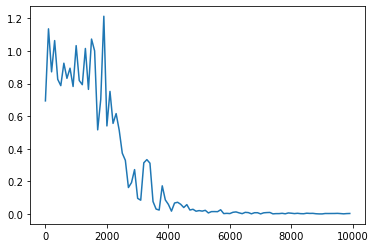

In [66]:
lists = range(0, iters_num, plot_interval)
plt.plot(lists, all_losses, label="loss")
plt.show()

* 誤差の描画
* 6000回目ほどで、誤差は0に収束している
___

# LSTM

### RNNの課題
* 時系列を遡れば遡るほど、勾配が消失していく→長い時系列の学習が困難

___

### 確認テスト③
#### Q.
シグモイド関数を微分した時、入力値が0の時に最大値をとる。その値として正しいものを選択肢から選べ。
#### A.
$
\sigma(0)=0.5\\
\frac{\partial \sigma(x)}{\partial x}=\sigma(x)(1-\sigma(x))
$

より、(2)0.25
___

### 勾配爆発
* 勾配が、層を逆伝播するごとに指数関数的に大きくなっていくこと
___

### LSTMの全体像
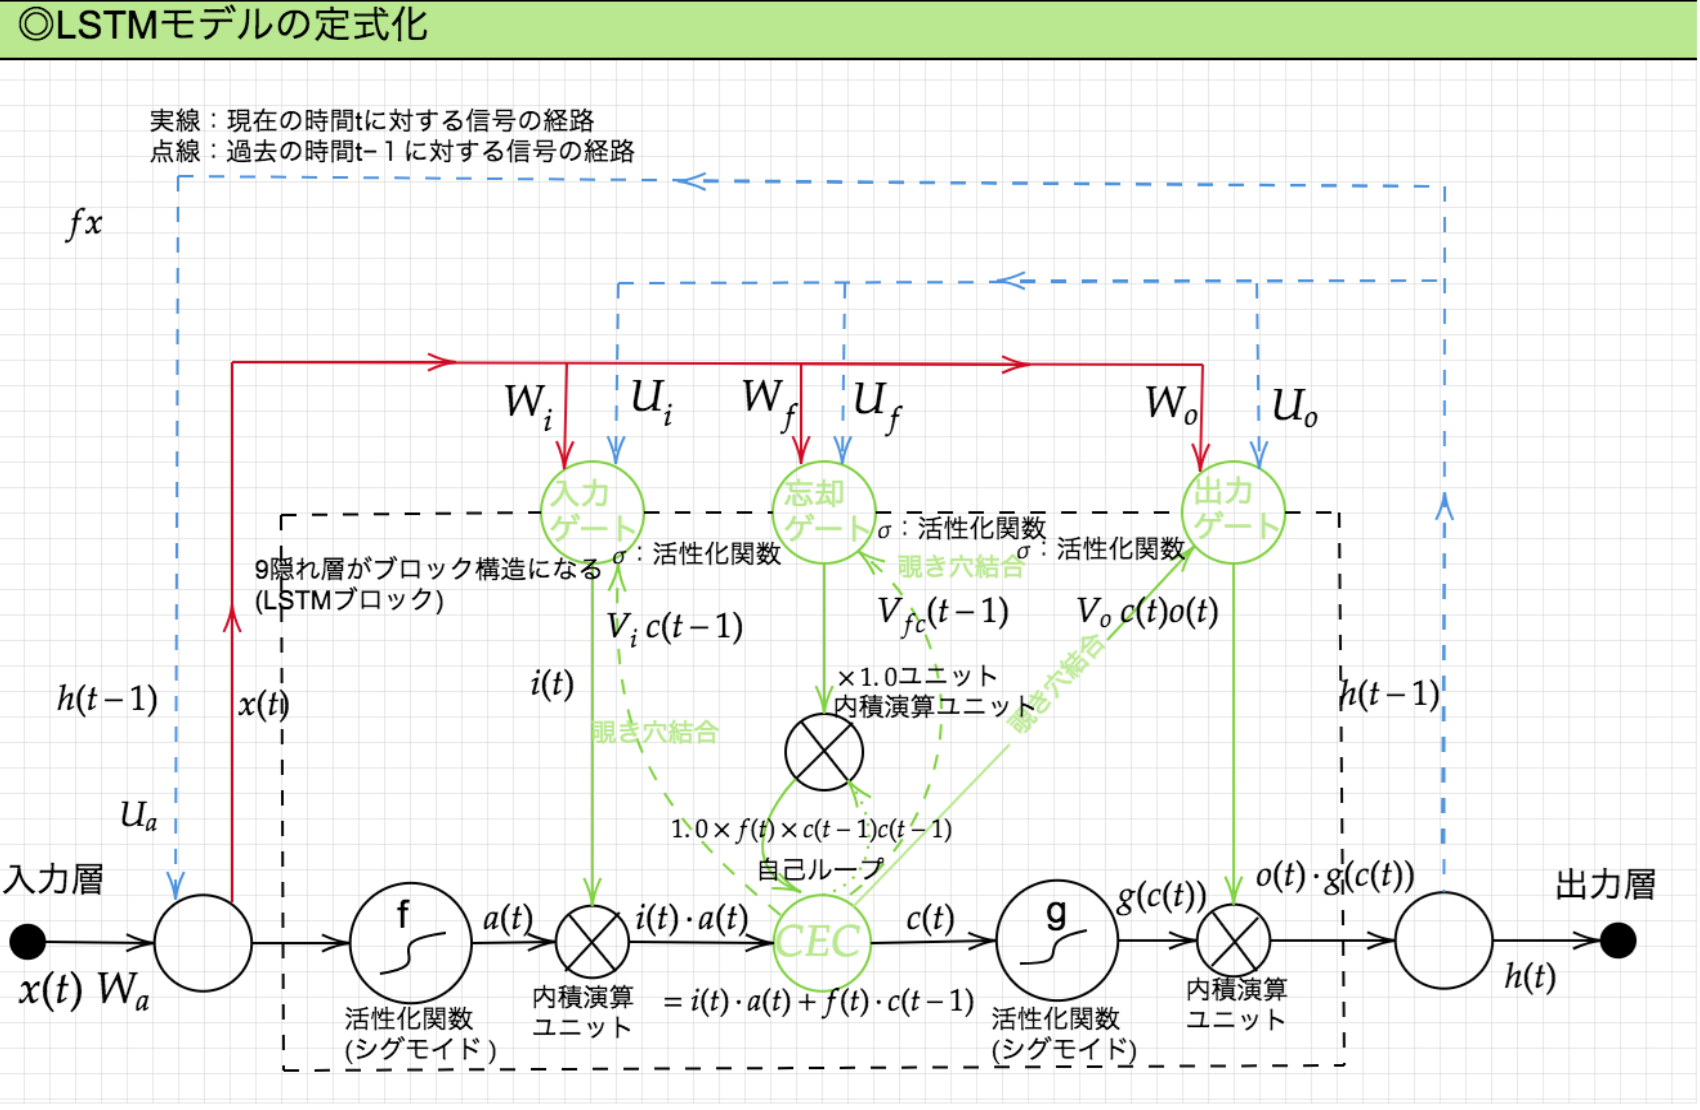
___

### CEC
$$c(t)=i(t)a(t)+f(t)c(t-1)$$
* 記憶機能だけをもつ
* 新しいセルの状態は、計算されたセルへの入力と1ステップ前のセルの状態に入力ゲート、忘却ゲートを掛けて足し合わせたものと表現される
* 勾配消失および勾配爆発の解決方法として、勾配が、1であれば解決できることを利用している
* 課題...入力データについて、時間依存度に関係なく重みが一律
___

### 入力・出力ゲート
* それぞれのゲートへの入力値の重みを、重み行列W,Uで可変可能にする
* CECの課題を解決
___

### LSTMブロックの課題
* 過去の情報が要らなくなった場合、削除することはできず、保管され続ける
* 過去の情報が要らなくなった場合、そのタイミングで情報を忘却する機能が必要
___

### 忘却ゲート
* 前回までの記憶をどれだけ残すかを決める
* CECの式としては、第二項にあたる
___

### 確認テスト④
#### Q.
以下の文章をLSTMに入力し空欄に当てはまる単語を予測したいとする。文中の「とても」という言葉は空欄の予測においてなくなっても影響を及ぼさないと考えられる。このような場合、どのゲートが作用すると考えられるか。

「映画おもしろかったね。ところで、とてもお腹が空いたから何か____。」
#### A.
忘却ゲート
___

### 覗き穴結合
* CEC自身の値に、重み行列を介して伝播可能にした構造
* CECの保存されている過去の情報を、任意のタイミングで他のノードに伝播させたり、あるいは任意のタイミングで忘却させたい
___

### ハンズオン
* 参考...https://www.anarchive-beta.com/entry/2021/01/10/180000

In [15]:
import numpy as np
from common.functions import sigmoid

* 必要なライブラリのインポート

In [10]:
class LSTM:
    # 初期化メソッドの定義
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # パラメータ
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 勾配
        self.cache = None
    
    # 順伝播メソッドの定義
    def forward(self, x, h_prev, c_prev):
        # パラメータと変数の形状に関する値を取得
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        # 結合したパラメータによる重み付き和の計算
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b
        
        # 各ゲートの重み付き和を取得
        f = A[:, :H]      # forgetゲート
        g = A[:, H:2*H]   # 記憶セル
        i = A[:, 2*H:3*H] # inputゲート
        o = A[:, 3*H:]    # outputゲート
        
        # ゲート値に変換
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)
        
        # 出力を計算
        c_next = f * c_prev + g * i  # 記憶セル
        h_next = o * np.tanh(c_next) # 出力データ
        
        # 逆伝播の計算用に変数を保存
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next
    
    # 逆伝播メソッドの定義
    def backward(self, dh_next, dc_next):
        # 変数を取得
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache
        
        # 計算用に活性化記憶セルを計算
        tanh_c_next = np.tanh(c_next)
        
        # 現レイヤの記憶セルの勾配を計算
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)
        
        # 前レイヤの記憶セルの勾配を計算
        dc_prev = ds * f
        
        # 活性化後のゲートの勾配を計算
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i
        
        # 活性化前のゲートの勾配を計算
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)
        
        # ゲートの勾配を結合
        dA = np.hstack((df, dg, di, do))
        
        # パラメータの勾配を計算
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)
        
        # パラメータの勾配を格納
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        # 入力の勾配を計算
        dx = np.dot(dA, Wx.T)
        dh_prev = np.dot(dA, Wh.T)
        
        return dx, dh_prev, dc_prev

* LSTMレイヤの実装

In [16]:
N = 5 # バッチサイズ
D = 15 # 単語ベクトル(Embedレイヤの中間層)のサイズ
H = 10 # 隠れ状態(Affineレイヤの中間層)のサイズ

x = np.random.rand(N, D) * 2 # Embedレイヤの出力
h_prev = np.random.rand(N, H) * 2 # 1つ前のLSTMレイヤの出力
c_prev = np.random.rand(N, H) * 2 # 1つ前のLSTMレイヤの記憶セル

Wx = np.random.randn(D, H * 4)
Wh = np.random.randn(H, H * 4)
b = np.zeros(H * 4)

* データとパラメータの形状に関する値を指定
* 入力データを作成

In [17]:
layer = LSTM(Wx, Wh, b)
h_next, c_next = layer.forward(x, h_prev, c_prev)

* インスタンスの作成
* 順伝播処理

In [18]:
dh_next = np.random.rand(N, H) * 2 # LSTMレイヤの出力
dc_next = np.random.rand(N, H) * 2 # LSTMレイヤの記憶セル

dx, dh_prev, dc_prev = layer.backward(dh_next, dc_next)

* 逆伝播の入力を簡易的に作成
* 逆伝播処理
___

# GRU 

### LSTMの課題
* LSTMでは、パラメータ数が多く、計算負荷が高くなる問題があった
___

### GRUとは
* LSTMのパラメータを大幅に削減し、精度は同等またはそれ以上が望める様になった構造
* メリット...計算負荷が低い
___

### GRUの全体像
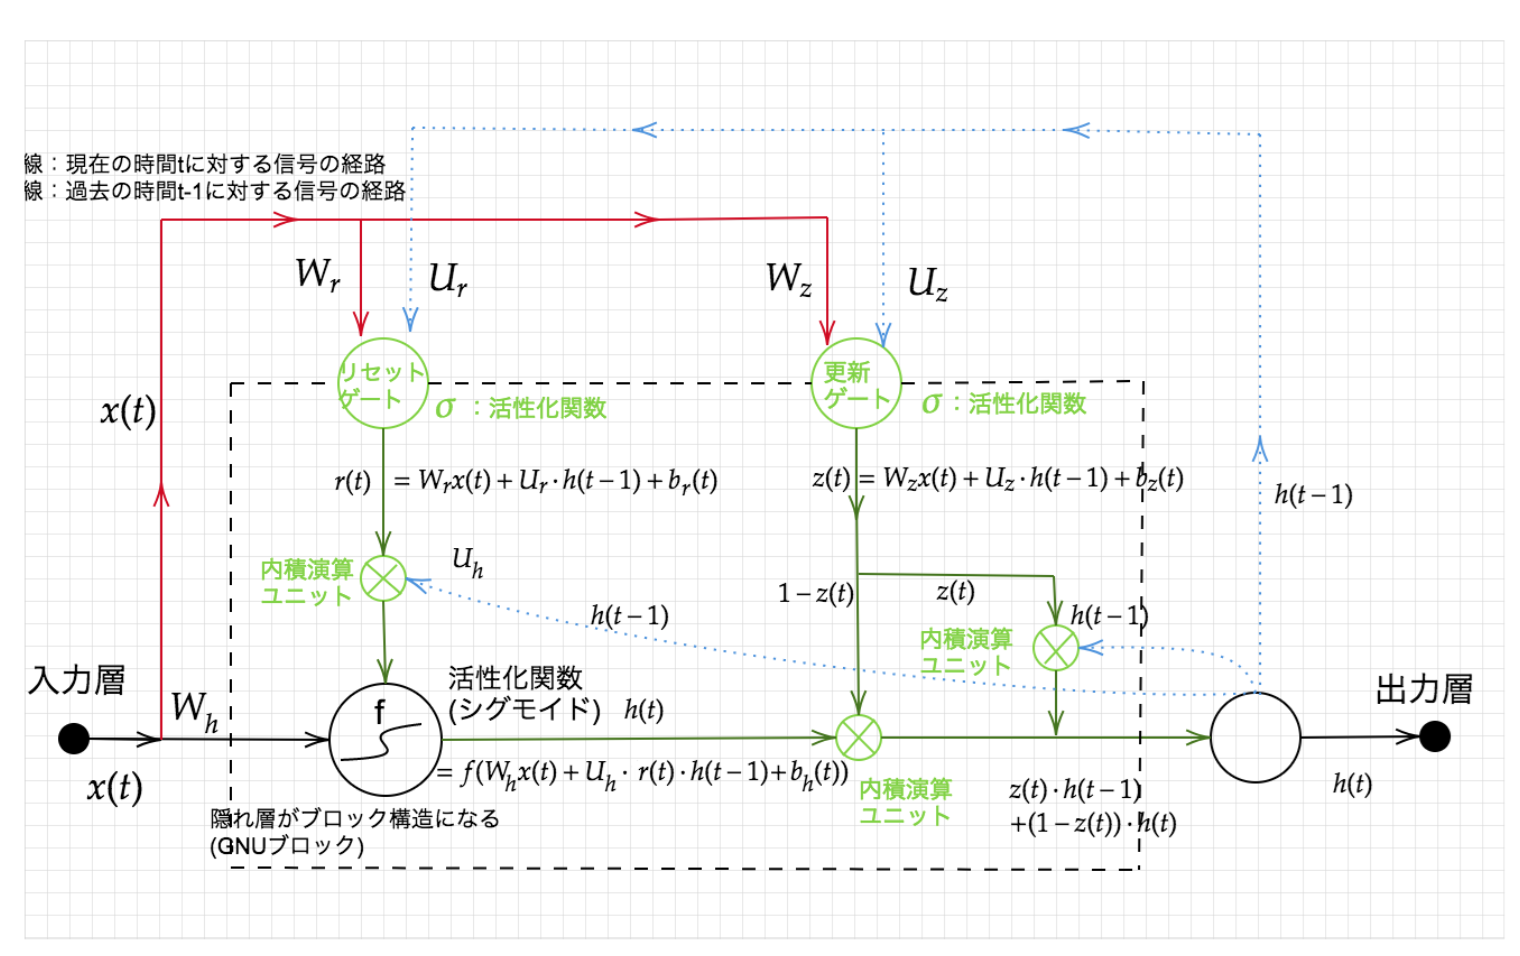
* CECがいなくなった
* 3のゲートが、リセットゲート、更新ゲートに置き換わった
___

### 確認テスト⑤
#### Q.
LSTMとCECが抱える課題について、それぞれ簡潔に述べよ。
#### A.
LSTM...パラメータ数が多く、計算負荷が高くなる
CEC...入力データについて、時間依存度に関係なく重みが一律
___

### ハンズオン

In [1]:
def gru(x, h, W_r, U_r, W_z, U_z, W, U):
    r = sigmoid(x.dot(W_r.T) + h.dot(U_r.T))
    z = sigmoid(x.dot(W_z.T) + h.dot(U_z.T))
    
    h_bar = np.tanh(x.dot(W.T) + (r*h).dot(U.T))
    h_new = (1-z) * h + z * h_bar
    return h_new

* リセットゲート、更新ゲートの対応コード
* 新しい中間状態は、1ステップ前の中間表現と計算された中間表現の線形和で表現される
___

### 確認テスト⑥
#### Q.
LSTMとGRUの違いを簡潔に述べよ。
#### A.
LSTMは3つのゲート、GRUは3つのゲートを持つ
___

# 双方向RNN

### 双方向RNN
* 過去の情報だけでなく、未来の情報を加味することで、精度を向上させるためのモデル